# Imports

In [1]:
from full_system_hamiltonian import *
from get_setup import params_for_n_site_Hamiltonian
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import expm
from numba import njit, objmode
from scipy.sparse.linalg import eigsh
import time


# Initialize params and operators

In [2]:
n_sites = 3
dupes = 3
big_N = n_sites * dupes

pars, extras = params_for_n_site_Hamiltonian(n_sites, configs=None, specified_vals={"U": [0.1]}, path="/home/Hishem/repos/MastersThesis/configuration.json")


t, U, eps, Delta = pars

print("t, U, eps, Delta =", t, U, eps, Delta)

t_couple = t 
delta_couple = Delta


t: [1. 1.]
U: [0.1 0.1]
eps: [-0.10097739030086553, -0.6071436946690216, -0.0032830574591187892]
Delta: [1.001265238594651, 1.0015039227972797]
t, U, eps, Delta = [1. 1.] [0.1 0.1] [-0.10097739030086553, -0.6071436946690216, -0.0032830574591187892] [1.001265238594651, 1.0015039227972797]


In [8]:
n, dup = n_sites, dupes
operators = {}
cre, ann, num = precompute_ops(big_N)
operators['cre'] = cre
operators['ann'] = ann
operators['num'] = num
hop_ops = {}
pair_ops = {}
dens_ops = {}
for d in range(dup):
    off = d * n
    for i in range(n-1):
        a, b = off+i, off+i+1
        hop_ops[(a,b)] = cre[a] @ ann[b] + ann[a] @ cre[b]
        pair_ops[(a,b)] = cre[a] @ cre[b] + ann[b] @ ann[a]
        dens_ops[(a,b)] = num[a] @ num[b]
# Inter PMM coupling terms
# Inner dots only for now
hop_ops[(0,n)] = cre[0] @ ann[n] + ann[0] @ cre[n] #A0 - B0
hop_ops[(0,2*n)] = cre[0] @ ann[2*n] + ann[0] @ cre[2*n] #A0 - C0
# hop_ops[(n,2*n)] = cre[n] @ ann[2*n] + ann[n] @ cre[2*n] #B0 - C0
operators['hop'] = hop_ops
operators['pair'] = pair_ops
operators['dens'] = dens_ops



# Create hamiltonian and delta pulse function

In [9]:
def simple_delta_pulse(t, T_peak, width, s, max_val,min_val):
    T_start = T_peak - width / 2
    T_end = T_peak + width / 2

    rise = 1/(1 + np.exp(-s*(t - T_start)))
    fall = 1/(1 + np.exp(s*(t - T_end)))

    return min_val + (max_val - min_val) * rise * fall


In [13]:

def hamiltonian(n, dup, t_vals, U_vals, eps_vals, delta_vals,
               couplings=(), eps_detune=None, operators=None):

    big_N = dup * n
    dim = 2**big_N
    H = np.zeros((dim, dim), dtype=complex)
    if operators is None:
        cre, ann, num = precompute_ops(big_N)
        hop_ops = {}
        pair_ops = {}
        dens_ops = {}
        for d in range(dup):
            off = d * n
            for i in range(n-1):
                a, b = off+i, off+i+1
                hop_ops[(a,b)] = cre[a] @ ann[b] + ann[a] @ cre[b]
                pair_ops[(a,b)] = cre[a] @ cre[b] + ann[b] @ ann[a]
                dens_ops[(a,b)] = num[a] @ num[b]
        # Inter PMM coupling terms
        # Inner dots only for now
        hop_ops[(0,n)] = cre[0] @ ann[n] + ann[0] @ cre[n] #A0 - B0
        hop_ops[(0,2*n)] = cre[0] @ ann[2*n] + ann[0] @ cre[2*n] #A0 - C0
        # hop_ops[(n,2*n)] = cre[n] @ ann[2*n] + ann[n] @ cre[2*n] #B0 - C0
    else:
        cre = operators["cre"]
        ann = operators["ann"]
        num = operators["num"]
        hop_ops = operators["hop"]
        pair_ops = operators["pair"]
        dens_ops = operators["dens"]
    # cre, ann, num = precompute_ops(big_N)

    eps_full = np.tile(eps_vals, (dup,1))
    if eps_detune is not None:
        for i in range(len(eps_detune)):
            site, node, val = eps_detune[i]
            eps_full[int(site), int(node)] = val


    # Intra PMM terms
    for d in range(dup):
        off = d * n
        for j in range(n-1):
            i, k = off+j, off+j+1
            # print(f"Adding intra-PMM terms between sites {i} and {k}")
            H += -t_vals[j]   * hop_ops[(i,k)]
            H +=  delta_vals[j] * pair_ops[(i,k)]
            H +=  U_vals[j]   * dens_ops[(i,k)]

        for j in range(n):
            H += eps_full[d,j] * num[off+j]


    #  Inter or additional PMM couplings
    for cA, cB, t_c, d_c in couplings:
        if cA is None or cB is None:
            continue

        i = cA[0]*n + cA[1]
        j = cB[0]*n + cB[1]
        key = (min(i,j), max(i,j))
        if t_c != 0:
            H += -t_c * hop_ops[key]
        if d_c != 0 and cA[0]*n == cB[0]*n:
            H +=  d_c * pair_ops[key]
        if cA[0] != cB[0] and d_c != 0:
            raise RuntimeError("Inter-PMM pairing forbidden")
    return H


# Test hamiltonian connections

In [ ]:
AB_coupling = [(0,2), (1,0), 0.0]
BC_coupling = [(1,0), (2,0), 0.0]
CA_coupling = [(2,0), (0,2), 0.0]

couplings = [
    AB_coupling,
    BC_coupling,
    CA_coupling
]

# eps_detune = None#{1: 0.0}
# eps_detune = [[0,0,0.0]] #site , node , val
H = hamiltonian(n_sites, dupes, t, U, eps, Delta, operators=operators)


eigvals, eigvecs = np.linalg.eigh(H)
print(eigvals[:10])

Adding intra-PMM terms between sites 0 and 1
Adding intra-PMM terms between sites 1 and 2
Adding intra-PMM terms between sites 3 and 4
Adding intra-PMM terms between sites 4 and 5
Adding intra-PMM terms between sites 6 and 7
Adding intra-PMM terms between sites 7 and 8
[-6.97300714 -6.97291322 -6.97291322 -6.97291322 -6.9728193  -6.9728193
 -6.9728193  -6.97272537 -5.20772486 -5.20772486]


Adding intra-PMM terms between sites 0 and 1
Adding intra-PMM terms between sites 1 and 2
Adding intra-PMM terms between sites 3 and 4
Adding intra-PMM terms between sites 4 and 5
Adding intra-PMM terms between sites 6 and 7
Adding intra-PMM terms between sites 7 and 8
8 8


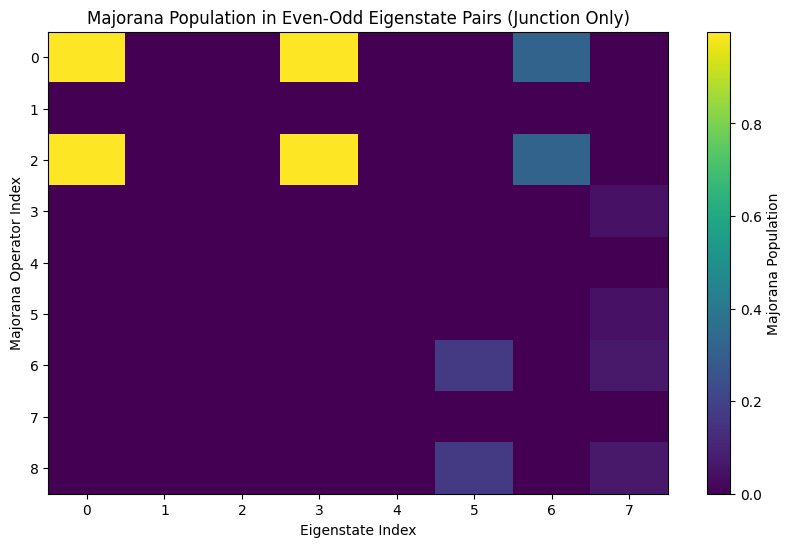

(8, 9)
(0.9982180777569261+0j)
(2.4084400877715983e-05+0j)
(2.4084400877716085e-05-0j)
(0.9982180777569252+0j)
(8.643762676057224e-06-0j)
(0.17144627784007382+0j)
(0.3177055780864195-0j)
(0.06660718597883011+0j)


/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


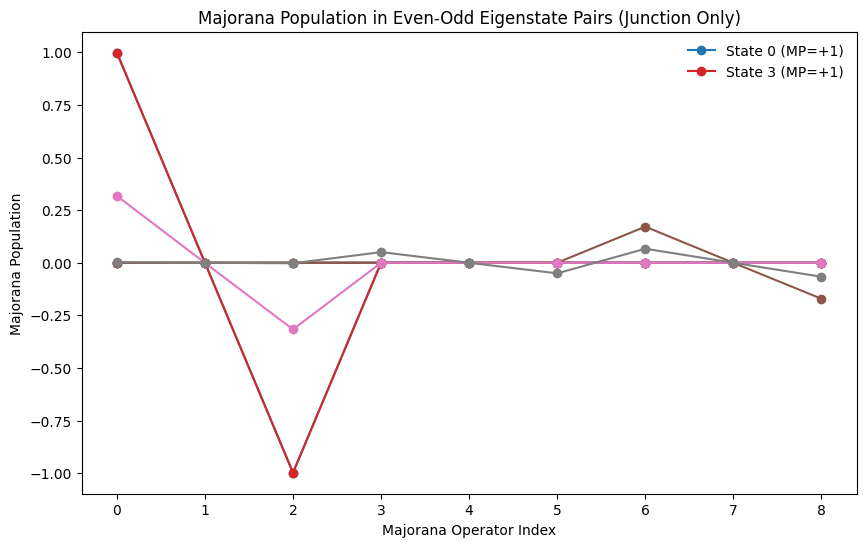

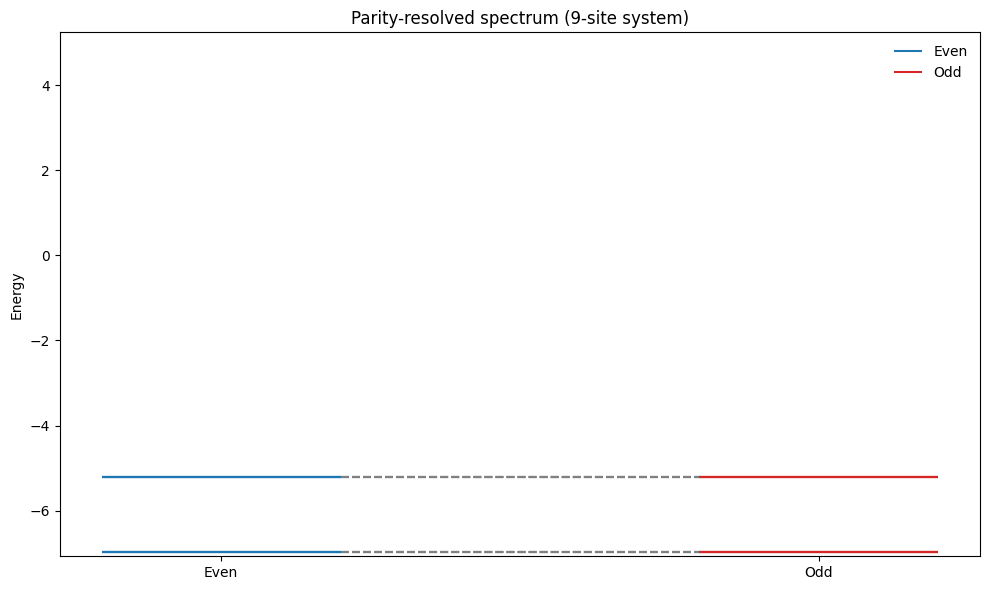

In [12]:
def majorana_operators(n):
    create, annihilate, number = precompute_ops(n)
    majorana_ops = []
    for j in range(n):
        f_dag = create[j]
        f = annihilate[j]
        gamma_1 = f + f_dag
        gamma_2 = -1j * (f - f_dag)
        majorana_ops.append((gamma_1, gamma_2))
    return majorana_ops



def calculate_parities(eigenvecs, eigenvals, number_ops):
    P = total_parity(number_ops)

    #find even and odd parity indexes
    parities = []
    for i in range(eigenvecs.shape[1]):
        vec = eigenvecs[:,i]
        parity = vec.conj().T @ P @ vec
        parities.append(parity.real)
    parities = np.array(parities)
    even_idxs = np.where(parities > 0)[0]
    odd_idxs = np.where(parities < 0)[0]

    even_energies = eigenvals[even_idxs]
    odd_energies = eigenvals[odd_idxs]

    even_vecs = eigenvecs[:, even_idxs]
    odd_vecs = eigenvecs[:, odd_idxs]

    return even_energies, odd_energies, even_vecs, odd_vecs, even_idxs, odd_idxs, parities


cutoff = 8
t, U, eps, Delta = pars
H = hamiltonian(n_sites, dupes, t, U, eps, Delta, operators=operators)
eigvals, eigvecs = np.linalg.eigh(H)
even_energies, odd_energies, even_vecs, odd_vecs, even_idxs, odd_idxs, parities = calculate_parities(eigvecs, eigvals, operators['num'])

even_vecs = even_vecs[:, :cutoff]
odd_vecs = odd_vecs[:, :cutoff]
even_energies = even_energies[:cutoff]
odd_energies = odd_energies[:cutoff]

# print(len(eigvals))
print(len(even_energies), len(odd_energies))
def majorana_population(even_vecs, odd_vecs, majorana_ops):
    M = np.zeros((even_vecs.shape[1], big_N), dtype=np.complex128)

    for j in range(big_N):
        Gamma_1, Gamma_2 = majorana_ops[j]
        for i in range(even_vecs.shape[1]):
            v_e = even_vecs[:, i]
            v_o = odd_vecs[:, i]
            term1 = np.vdot(v_o, Gamma_1 @ v_e)
            term2 = np.vdot(v_o, Gamma_2 @ v_e)
            M[i, j] = term1**2 + term2**2
    return M


majorana_ops = majorana_operators(big_N)



M = majorana_population(even_vecs, odd_vecs, majorana_ops)
plt.figure(figsize=(10,6))
plt.imshow(abs(M.T), aspect='auto', cmap='viridis')
plt.colorbar(label='Majorana Population')
plt.ylabel('Majorana Operator Index')
plt.xlabel('Eigenstate Index')
plt.xticks(ticks=np.arange(M.shape[0]), labels=np.arange(M.shape[0]))
plt.title('Majorana Population in Even-Odd Eigenstate Pairs (Junction Only)')
plt.show()

#give label to those with MP ±1
labels = []
print(M.shape)
for i in range(M.shape[0]):
    print(np.max(M[i,:]))
    if np.isclose(np.max(M[i,:]), 1.0, atol=1e-2):
        labels.append(f'State {i} (MP=+1)')
    elif np.isclose(np.min(M[i,:]), -1.0, atol=1e-2):
        labels.append(f'State {i} (MP=-1)')
    else:
        # continue
        labels.append('')

plt.figure(figsize=(10,6))
for i in range(M.shape[0]):
    plt.plot(range(big_N), M[i], 'o-', label=labels[i] if labels[i] != '' else labels[i])
plt.xlabel('Majorana Operator Index')
plt.ylabel('Majorana Population')
plt.title('Majorana Population in Even-Odd Eigenstate Pairs (Junction Only)')
plt.legend(frameon=False)
plt.show()


plt.figure(figsize=(10,6))
y_even = even_energies
y_odd = odd_energies
degeneracies = []
for ye in y_even:
    for yo in y_odd:
        if np.isclose(ye, yo, atol=1e-2):
            degeneracies.append((ye + yo) / 2)
            break

plt.hlines(y_even, -0.2, 0.2, color='tab:blue', label='Even')
plt.hlines(y_odd,  0.8, 1.2, color='tab:red', label='Odd')
plt.hlines(degeneracies, 0.2, 0.8, color='gray', linestyles='--')
plt.ylim(eigvals.min() - 0.1, eigvals.max() + 0.1)
plt.xticks([0, 1], ["Even", "Odd"])
plt.ylabel("Energy")
plt.title(f"Parity-resolved spectrum ({big_N}-site system)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


# Evolve the system

In [15]:
def evolve_system(Total_time, time_steps, params, tJ, dJ, eps_detune_val):
    """ 
    Information about setup:
    A, B, C = 1, 2, 3
    inner, middle, outer = 0, 1, 2
    Relevant γ's:
    γ_0 = (site 0, node 0)
    γ_1 = (site 0, node 2)
    γ_2 = (site 1, node 0)
    γ_3 = (site 2, node 0)

    Order of connections:
    T = 0:
        γ_0 -- γ_1
            default
            eps_detune = [[B, outer, eps_detune_val], [C, outer, eps_detune_val]]
    T = 1/3 Total_time:
        γ_0 -- γ_2
            junction_couplings = [AB_coupling]
            eps_detune = [[A, outer, eps_detune_val], [B, outer, eps_detune_val]]
    T = 2/3 Total_time:
        γ_0 -- γ_3
            junction_couplings = [AC_coupling]
            eps_detune = [[A, outer, eps_detune_val], [C, outer, eps_detune_val]]
    T = Total_time:
        γ_0 -- γ_1
            Default 
            eps_detune = [[B, outer, eps_detune_val], [C, outer, eps_detune_val]]
    """
    #Base parameters
    t_val, U_val, eps_val, Delta_val = params
    width = Total_time / 3
    s = 20/width#

    dT, dD = 5, 5  # Add perturbations to intra PMM couplings

    #System setup
    A, B, C = 0, 1, 2
    outer, middle, inner = 2, 1, 0

    time_array = np.linspace(0, Total_time, time_steps)
    eps_detune_min = eps_val[0]
    eps_detune = []
    couplings = []
    for i in range(len(time_array)):
        t = time_array[i]

        #Tune chemical potentials for detuning
        detune_A = simple_delta_pulse(t, Total_time/2, 2*width, s, eps_detune_val, eps_detune_min)
        #simple_delta_pulse(t, Total_time/3, width, s, eps_detune_val, eps_detune_min) + simple_delta_pulse(t, 2*Total_time/3, width, s, eps_detune_val, eps_detune_min) - eps_detune_min
        
        tj_pulse_AB = simple_delta_pulse(t, Total_time/3, width, s, tJ, 0.0)
        tj_pulse_AC = simple_delta_pulse(t, 2*Total_time/3, width, s, tJ, 0.0)


        # detune_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * eps_detune_val  - eps_detune_min 

        eps_detune.append([[A, outer, detune_A]])

        tj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (tJ + dT) #- tJ
        dj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (dJ + dD) #- dJ


        # dJ_pulse_AB = simple_delta_pulse(t, Total_time/3, width, s, dJ, 0.0)
        # dJ_pulse_AC = simple_delta_pulse(t, 2*Total_time/3, width, s, dJ, 0.0)

        coups = [[(A, inner), (B, inner), tj_pulse_AB, 0.0],
                 [(C, inner), (A, inner), tj_pulse_AC, 0.0],
                 [(A, inner), (A, middle), tj_pulse_A, dj_pulse_A],
                 [(A, middle), (A, outer), tj_pulse_A, dj_pulse_A]
                 ]
        couplings.append(coups)

    dim = 2**big_N//2
    eigvals = np.zeros((time_steps, dim), dtype=complex)
    eigvecs = np.zeros((time_steps, dim, dim), dtype=complex)
    gap = np.zeros(time_steps, dtype=complex)

    parity_op = total_parity(operators['num'])
    P_eigvals, P_eigvecs = np.linalg.eigh(parity_op)
    even_idxs = np.where(P_eigvals > 0)[0]
    odd_idxs = np.where(P_eigvals < 0)[0]

    for i in tqdm(range(len(time_array))):

        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val,
                          couplings=couplings[i],
                          eps_detune=eps_detune[i],
                          operators=operators)
        # eigvals_t, eigvecs_t = np.linalg.eigh(H_t)
        H_proj = P_eigvecs[:, even_idxs].conj().T @ H_t @ P_eigvecs[:, even_idxs]

        eigvals_t, eigvecs_t = np.linalg.eigh(H_proj)

        eigvals[i] = eigvals_t
        eigvecs[i] = eigvecs_t
        gap[i] = eigvals_t[2] - eigvals_t[1]


    return time_array, couplings, eps_detune, eigvals, eigvecs, gap


Total_time = 300.0
n_time_steps = 1000
tJ = t_couple[0]
dJ = delta_couple[0]
eps_detune_val = tJ*1.5

time_array, couplings, eps_detune, eigvals, eigvecs, gap = evolve_system(Total_time, n_time_steps, pars, tJ, dJ, eps_detune_val)


100%|██████████| 1000/1000 [00:22<00:00, 44.22it/s]


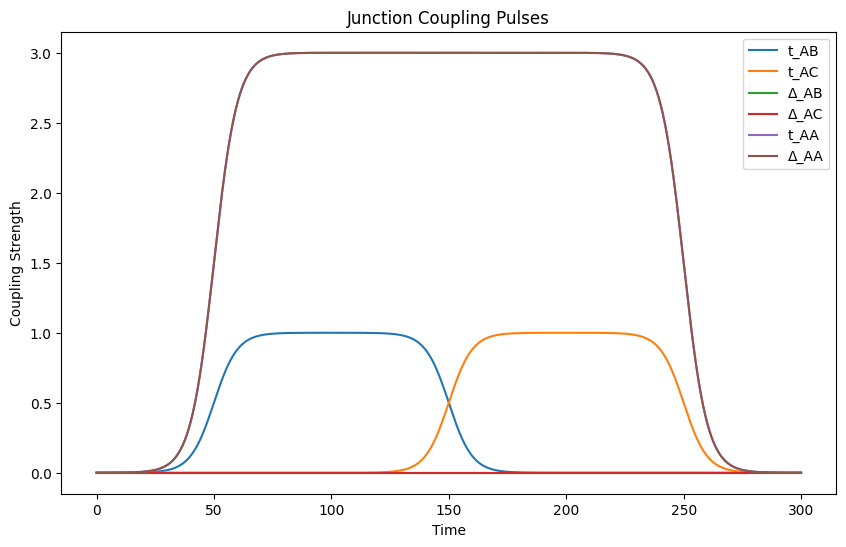

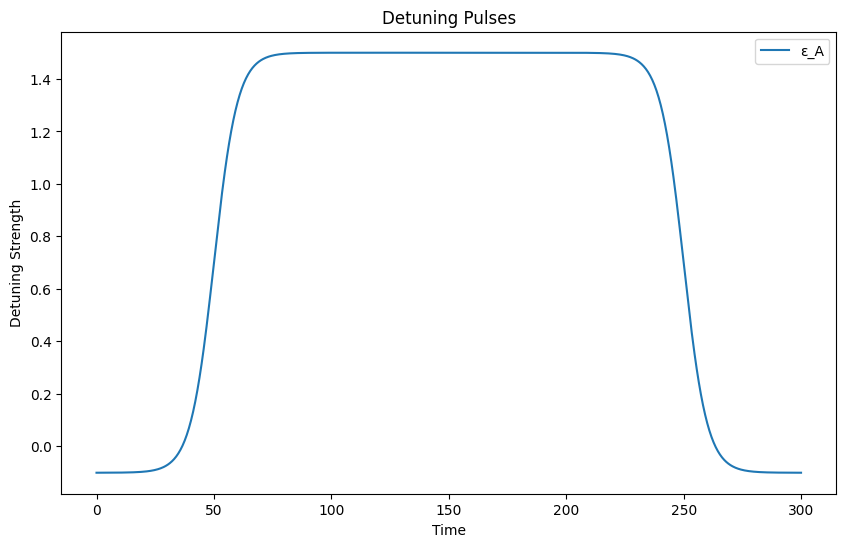

/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


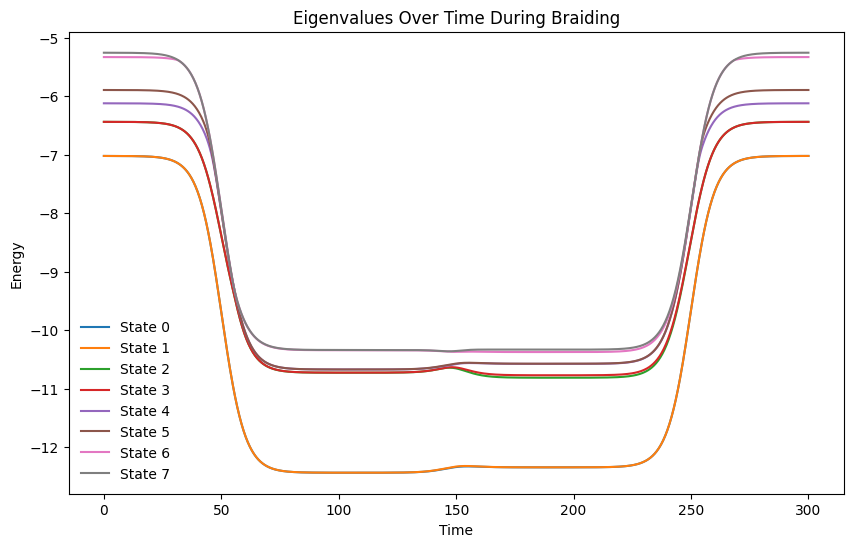

In [16]:

ab_pulse_tJ = [c[0][2] for c in couplings]
ab_pulse_dJ = [c[0][3] for c in couplings]
ac_pulse_tJ = [c[1][2] for c in couplings]
ac_pulse_dJ = [c[1][3] for c in couplings]
aa_pulse_tJ = [c[2][2] for c in couplings]
aa_pulse_dJ = [c[2][3] for c in couplings]
# bc_pulse_tJ = [c[1][2] for c in couplings]
# bc_pulse_dJ = [c[1][3] for c in couplings]
#plot pulses
plt.figure(figsize=(10,6))
plt.plot(time_array, ab_pulse_tJ, label='t_AB')
plt.plot(time_array, ac_pulse_tJ, label='t_AC')
plt.plot(time_array, ab_pulse_dJ, label='Δ_AB')
plt.plot(time_array, ac_pulse_dJ, label='Δ_AC')
plt.plot(time_array, aa_pulse_tJ, label='t_AA')
plt.plot(time_array, aa_pulse_dJ, label='Δ_AA')
# plt.plot(time_array, bc_pulse_tJ, label='t_BC')
# plt.plot(time_array, bc_pulse_dJ, label='Δ_BC')

plt.xlabel('Time')
plt.ylabel('Coupling Strength')
plt.title('Junction Coupling Pulses')
plt.legend()
plt.show()

#plot detuning pulses
plt.figure(figsize=(10,6))
# plt.plot(time_array, eps_detune_val, label='ε_A')
plt.plot(time_array, [d[0][2] for d in eps_detune], label='ε_A')
# plt.plot(time_array, [d[1][2] for d in eps_detune], label='ε_B')
# plt.plot(time_array, [d[2][2] for d in eps_detune], label='ε_C')
plt.xlabel('Time')
plt.ylabel('Detuning Strength')
plt.title('Detuning Pulses')
plt.legend()
plt.show()

eigvals_cut = eigvals[:, :8]
#plot eigenvalues over time
plt.figure(figsize=(10,6))
for i in range(eigvals_cut.shape[1]):
    plt.plot(time_array, eigvals_cut[:,i], label=f'State {i}')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Eigenvalues Over Time During Braiding')
plt.legend(frameon=False)
plt.show()  



# Verify the results

In [17]:
def find_ground_state_idxs(eigvals, tol=1e-2):
    E0 = eigvals.min()
    return np.where(np.abs(eigvals - E0) < tol)[0]

def ground_eigenvectors(H, tol=1e-2):
    eigvals, eigvecs = np.linalg.eigh(H)
    ground_state_idxs = find_ground_state_idxs(eigvals, tol=tol)
    return eigvecs[:, ground_state_idxs], ground_state_idxs

def evolve_basis(Total_time, time_steps, params, couplings, detunes, P_even):

    t_val, U_val, eps_val, Delta_val = params
    time_array = np.linspace(0, Total_time, time_steps)

    # --- Initial Hamiltonian ---
    H0_full = hamiltonian(
        n_sites, dupes, t_val, U_val, eps_val, Delta_val,
        couplings=couplings[0],
        eps_detune=detunes[0],
        operators=operators
    )

    # Project to even parity
    H0 = P_even.conj().T @ H0_full @ P_even

    eigvals_0, eigvecs_0 = np.linalg.eigh(H0)

    cutoff = 2  
    phi_prev = eigvecs_0[:, :cutoff].copy()
    phi0 = phi_prev.copy()

    U = np.eye(cutoff, dtype=complex)

    # --- Kato evolution ---
    for i in tqdm(range(1, len(time_array))):

        H_full = hamiltonian(
            n_sites, dupes, t_val, U_val, eps_val, Delta_val,
            couplings=couplings[i],
            eps_detune=detunes[i],
            operators=operators
        )

        H = P_even.conj().T @ H_full @ P_even

        _, eigvecs = np.linalg.eigh(H)
        phi = eigvecs[:, :cutoff]

        # Overlap matrix
        M = phi_prev.conj().T @ phi

        # Gauge fixing
        Uu, _, Vh = np.linalg.svd(M)
        M_gauge = Vh.conj().T @ Uu.conj().T

        U = M_gauge @ U
        phi_prev = phi

    return phi0, phi_prev, U


P_op = total_parity(operators['num'])
P_eigvals, P_eigvecs = np.linalg.eigh(P_op)
even_idxs = np.where(P_eigvals > 0)[0]
P_even = P_eigvecs[:, even_idxs]

phi0, phi, U_berry = evolve_basis(Total_time, n_time_steps, pars, couplings, eps_detune, P_even)

# print("Initial ground states shape:", phi0.shape)
# print("phi0:", phi0)
# print("Final ground states shape:", phi.shape)
# print("phi:", phi)
print("Braiding unitary shape:", U_berry.shape)

#Calculate U_berry eigvals
print("Braiding unitary eigenvalues:")
U_eigvals = np.linalg.eigvals(U_berry)
for val in U_eigvals:
    angle = np.angle(val)
    print(f"Eigenvalue: {val:.4f}, Angle: {angle:.4f} rad, {angle*180/np.pi:.2f}°")

100%|██████████| 999/999 [00:25<00:00, 38.72it/s]

Braiding unitary shape: (2, 2)
Braiding unitary eigenvalues:
Eigenvalue: -1.0000+0.0000j, Angle: 3.1416 rad, 180.00°
Eigenvalue: 1.0000+0.0000j, Angle: 0.0000 rad, 0.00°


In [18]:
np.linalg.norm(U_berry.conj().T @ U_berry - np.eye(2)) #Close to zero -> numerically clean

np.float64(1.1954019207959142e-13)

Max leakage during braiding: 0.015292187483636137


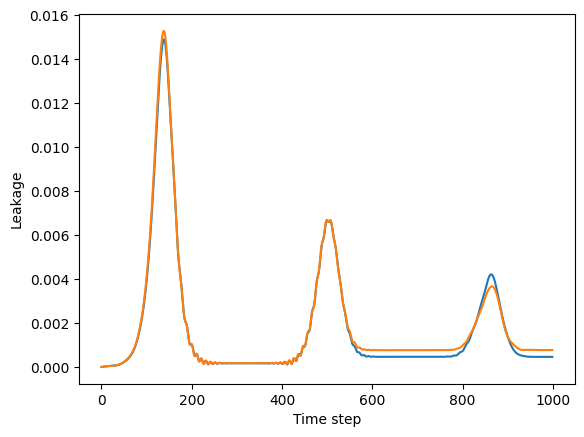

In [19]:
def check_adiabatic_leakage(time_array,eigvals,eigvecs,cutoff):
    """
    Checks leakage out of instantaneous ground space.

    Returns:
        leakages[t, a] = leakage of initial ground state a at time t
    """

    dt = time_array[1] - time_array[0]
    dim = eigvecs.shape[1]
    Ng = cutoff
    I = np.eye(dim)

    psi0 = eigvecs[0][:, :Ng]

    leakages = np.zeros((len(time_array), Ng))

    # Evolve each ground state independently
    for a in range(Ng):
        psi = psi0[:, a].copy()

        for t in range(len(time_array)):
            # Instantaneous ground projector
            Phi_t = eigvecs[t][:, :Ng]
            P0 = Phi_t @ Phi_t.conj().T

            # Leakage
            leak = np.linalg.norm((I - P0) @ psi)
            leakages[t, a] = leak

            # Time evolve (except last step)
            if t < len(time_array) - 1:
                H_diag = np.diag(eigvals[t])
                U_dt = expm(-1j * H_diag * dt)
                psi = eigvecs[t] @ (U_dt @ (eigvecs[t].conj().T @ psi))

    return leakages

leakages = check_adiabatic_leakage(time_array, eigvals, eigvecs, cutoff=2)
print("Max leakage during braiding:", np.max(leakages))

plt.plot(leakages)
# plt.yscale("log")
plt.xlabel("Time step")
plt.ylabel("Leakage")
plt.show()


In [20]:
steps = [0, n_time_steps//3, 2*n_time_steps//3, n_time_steps-1]

t, U, eps, Delta = pars

H0 = hamiltonian(n_sites, dupes, t, U, eps, Delta, couplings=couplings[0], eps_detune=eps_detune[0], operators=operators)
H1 = hamiltonian(n_sites, dupes, t, U, eps, Delta, couplings=couplings[steps[1]], eps_detune=eps_detune[steps[1]], operators=operators)
H2 = hamiltonian(n_sites, dupes, t, U, eps, Delta, couplings=couplings[steps[2]], eps_detune=eps_detune[steps[2]], operators=operators)
H3 = hamiltonian(n_sites, dupes, t  , U, eps, Delta, couplings=couplings[steps[3]], eps_detune=eps_detune[steps[3]], operators=operators)
P_full = total_parity(operators['num'])

for i in range(4):
    Hi = [H0, H1, H2, H3][i]
    comm_norm = np.linalg.norm(Hi @ P_full - P_full @ Hi)
    print(f"Comm norm [H{i}, P]: {comm_norm:.3e}")

phi0_full = P_even @ phi0   # shape (512, 2)

# Expectation of parity
P_exp = np.diag(phi0_full.conj().T @ P_full @ phi0_full)
print(P_exp)

Comm norm [H0, P]: 0.000e+00
Comm norm [H1, P]: 0.000e+00
Comm norm [H2, P]: 0.000e+00
Comm norm [H3, P]: 0.000e+00
[1.+0.j 1.+0.j]


In [21]:
def strip_global_phase(U):
    return U / np.sqrt(np.linalg.det(U))

U_phys = strip_global_phase(U_berry)

print("U (phase stripped):")
print(U_phys)

print("Eigenphases:")
print(np.angle(np.linalg.eigvals(U_phys)))

U (phase stripped):
[[0.+0.9999707j 0.-0.0076547j]
 [0.-0.0076547j 0.-0.9999707j]]
Eigenphases:
[ 1.57079633 -1.57079633]


In [22]:
sx = np.array([[0,1],[1,0]], dtype=complex)
sy = np.array([[0,-1j],[1j,0]], dtype=complex)
sz = np.array([[1,0],[0,-1]], dtype=complex)

theta = np.arccos(np.real(np.trace(U_berry))/2)
print("theta =", theta)

for name, s in zip(["X","Y","Z"], [sx, sy, sz]):
    comp = 1j * np.trace(U_berry @ s) / (2*np.sin(theta))
    print(f"{name} component:", comp)

theta = 1.5707963267948852
X component: 0.00765470181855701j
Y component: (-1.1280039402539188e-15+0j)
Z component: (-0-0.9999707023408988j)


# Explore subsystem A

In [ ]:
t_val, U_val, eps_val, Delta_val = pars

eps_detune_val = t_val[0]*1.5

tJ, dJ = 5.0, 5.0

def evolve_subsystem_A(Total_time, time_steps, n, dupes, params, tJ, dJ, eps_detune_val):
    #Calculate the operators for only subsystem A
    big_N = n * dupes
    cre, ann, num = precompute_ops(big_N)
    operators['cre'] = cre
    operators['ann'] = ann
    operators['num'] = num
    hop_ops = {}
    pair_ops = {}
    dens_ops = {}
    for i in range(dupes):
        off = i * n
        for j in range(n-1):
            a, b = off+j, off+j+1
            hop_ops[(a,b)] = cre[a] @ ann[b] + ann[a] @ cre[b]
            pair_ops[(a,b)] = cre[a] @ cre[b] + ann[b] @ ann[a]
            dens_ops[(a,b)] = num[a] @ num[b]
    operators['hop'] = hop_ops
    operators['pair'] = pair_ops
    operators['dens'] = dens_ops



    
    t_val, U_val, eps_val, Delta_val = params
    
    print("t values:", t_val)
    print("U values:", U_val)
    print("Eps values:", eps_val)
    print("Delta values:", Delta_val)
    print("tJ =", tJ, "dJ =", dJ)
    print("eps_detune_val =", eps_detune_val)
    width = Total_time / 3
    s = 20/width#

    dT, dD = 5, 5  # Add perturbations to intra PMM couplings

    #System setup
    A, B, C = 0, 1, 2
    outer, middle, inner = 2, 1, 0

    time_array = np.linspace(0, Total_time, time_steps)
    eps_detune_min = eps_val[0]
    eps_detune = []
    couplings = []
    for i in range(len(time_array)):
        t = time_array[i]

        #Tune chemical potentials for detuning
        detune_A = simple_delta_pulse(t, Total_time/2, 2*width, s, eps_detune_val, eps_detune_min)
        
        tj_pulse_AB = simple_delta_pulse(t, Total_time/3, width, s, tJ, 0.0)
        tj_pulse_AC = simple_delta_pulse(t, 2*Total_time/3, width, s, tJ, 0.0)

        eps_detune.append([[A, outer, detune_A]])

        tj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (tJ + dT) #- tJ
        dj_pulse_A = (tj_pulse_AB + tj_pulse_AC) / np.linalg.norm(2*tJ) * (dJ + dD) #- dJ


        # dJ_pulse_AB = simple_delta_pulse(t, Total_time/3, width, s, dJ, 0.0)
        # dJ_pulse_AC = simple_delta_pulse(t, 2*Total_time/3, width, s, dJ, 0.0)

        coups = [[(A, inner), (A, middle), tj_pulse_A, dj_pulse_A],
                 [(A, middle), (A, outer), tj_pulse_A, dj_pulse_A]
                 ]
        couplings.append(coups)

    dim = 2**big_N
    # eigvals_even = np.zeros((time_steps, dim), dtype=complex)
    # eigvecs_even = np.zeros((time_steps, dim, dim), dtype=complex)

    # eigvals_odd = np.zeros((time_steps, dim), dtype=complex)
    # eigvecs_odd = np.zeros((time_steps, dim, dim), dtype=complex)

    eigvals = np.zeros((time_steps, dim), dtype=complex)
    eigvecs = np.zeros((time_steps, dim, dim), dtype=complex)
    gap = np.zeros(time_steps, dtype=complex)


    # P_op = total_parity(operators['num'])
    # P_eigvals, P_eigvecs = np.linalg.eigh(P_op)
    # even_idxs = np.where(P_eigvals > 0)[0]
    # odd_idxs = np.where(P_eigvals < 0)[0]

    # P_even = P_eigvecs[:, even_idxs]
    # P_odd = P_eigvecs[:, odd_idxs]

    for i in tqdm(range(len(time_array))):

        H_t = hamiltonian(n, dupes, t_val, U_val, eps_val, Delta_val,
                          couplings=couplings[i],
                          eps_detune=eps_detune[i],
                          operators=operators)
        eigvals_t, eigvecs_t = np.linalg.eigh(H_t)
        eigvals[i] = eigvals_t
        eigvecs[i] = eigvecs_t
        gap[i] = eigvals_t[1] - eigvals_t[0]

    return time_array, couplings, eps_detune, eigvals, eigvecs, gap, operators

time_array_A, couplings_A, eps_detune_A, eigvals_A, eigvecs_A, gap_A, operators_A = evolve_subsystem_A(Total_time, n_time_steps, 3, 1, pars, tJ, dJ, eps_detune_val)

t values: [1. 1.]
U values: [0.1 0.1]
Eps values: [-0.10097739030086553, -0.6071436946690216, -0.0032830574591187892]
Delta values: [1.001265238594651, 1.0015039227972797]
tJ = 5.0 dJ = 5.0
eps_detune_val = 1.5


100%|██████████| 1000/1000 [00:00<00:00, 32181.94it/s]


/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


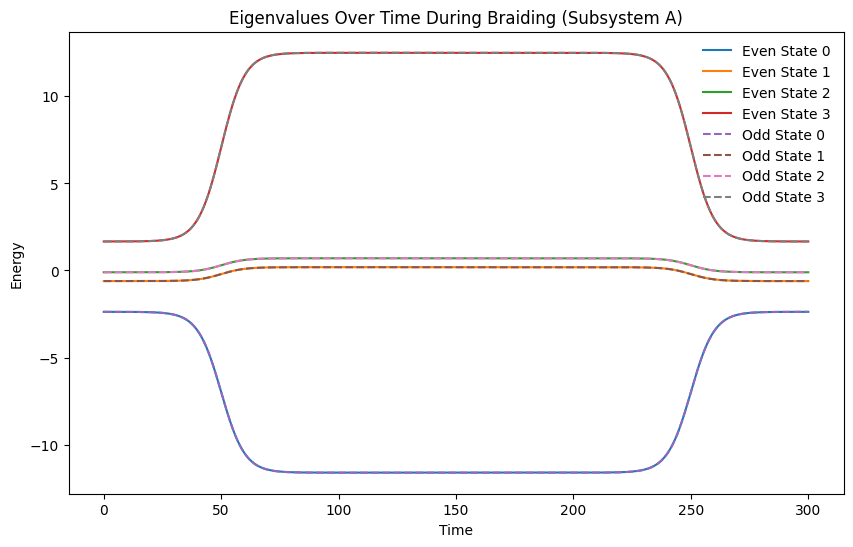

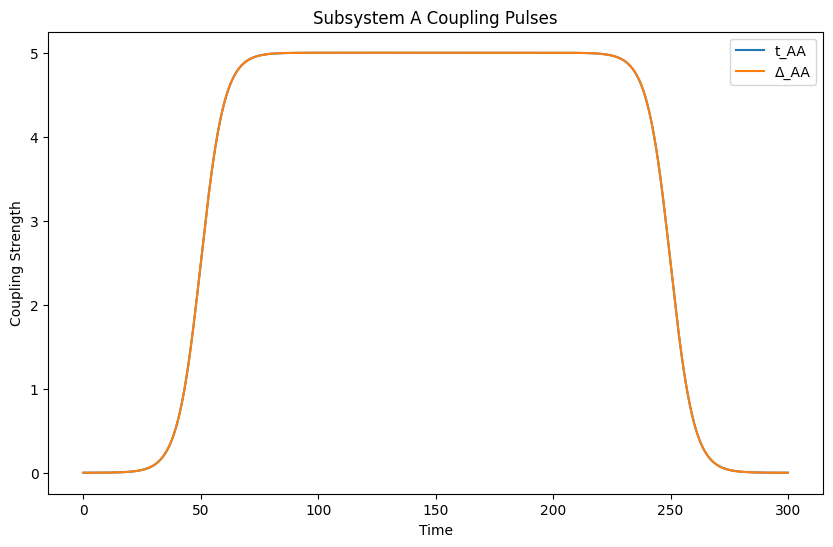

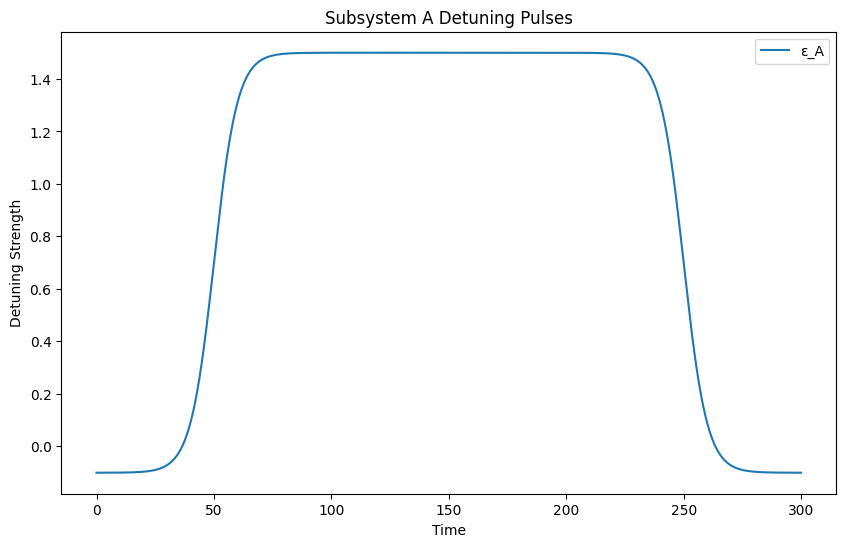

In [37]:
def collect_parity_arrays(eigvals, eigvecs, time_array):


    def calculate_parities(eigenvecs, eigenvals, P):
        parities = np.sum(eigenvecs.conj().T @ P @ eigenvecs, axis=0).real
        even_idxs = np.where(parities > 0)[0]
        odd_idxs = np.where(parities < 0)[0]

        even_energies = eigenvals[even_idxs]
        odd_energies = eigenvals[odd_idxs]

        even_vecs = eigenvecs[:, even_idxs]
        odd_vecs = eigenvecs[:, odd_idxs]

        return even_energies, odd_energies, even_vecs, odd_vecs

    dim = eigvecs.shape[1]
    dimhalf = eigvecs.shape[1] // 2

    even_vals = np.zeros((len(time_array), dimhalf), dtype=complex)
    odd_vals = np.zeros((len(time_array), dimhalf), dtype=complex)
    even_vecs = np.zeros((len(time_array), dim, dimhalf), dtype=complex)
    odd_vecs = np.zeros((len(time_array), dim, dimhalf), dtype=complex)



    for idx, time_idx in enumerate(time_array):
        even_energies, odd_energies, even_vecs_t, odd_vecs_t = calculate_parities(eigvecs[time_idx], eigvals[time_idx], total_parity(operators['num']))
        even_vals[idx,:len(even_energies)] = even_energies
        odd_vals[idx,:len(odd_energies)] = odd_energies
        even_vecs[idx,:,:len(even_energies)] = even_vecs_t
        odd_vecs[idx,:,:len(odd_energies)] = odd_vecs_t


    return even_vals, odd_vals, even_vecs, odd_vecs
eigvals_even_A, eigvals_odd_A, eigvecs_even_A, eigvecs_odd_A = collect_parity_arrays(eigvals_A, eigvecs_A, range(len(time_array_A)))

# # Plot eigenvalues over time for subsystem A
plt.figure(figsize=(10,6))
for i in range(len(eigvals_even_A[0])):
    plt.plot(time_array_A, eigvals_even_A[:,i], label=f'Even State {i}')
for i in range(len(eigvals_odd_A[0])):
    plt.plot(time_array_A, eigvals_odd_A[:,i], label=f'Odd State {i}', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Eigenvalues Over Time During Braiding (Subsystem A)')
plt.legend(frameon=False)
plt.show()


#plot couplings for subsystem A
aa_pulse_tJ_A = [c[0][2] for c in couplings_A]
aa_pulse_dJ_A = [c[0][3] for c in couplings_A]
plt.figure(figsize=(10,6))
plt.plot(time_array_A, aa_pulse_tJ_A, label='t_AA')
plt.plot(time_array_A, aa_pulse_dJ_A, label='Δ_AA')
plt.xlabel('Time')
plt.ylabel('Coupling Strength')
plt.title('Subsystem A Coupling Pulses')
plt.legend()
plt.show()

#plot detuning pulses for subsystem A
plt.figure(figsize=(10,6))
plt.plot(time_array_A, [d[0][2] for d in eps_detune_A], label='ε_A')
plt.xlabel('Time')      
plt.ylabel('Detuning Strength')
plt.title('Subsystem A Detuning Pulses')
plt.legend()
plt.show()

[[ 9.98822842e-01+0.j  1.73483167e-06-0.j -9.98824577e-01+0.j]
 [ 9.99998443e-01+0.j  3.41874881e-08+0.j -9.99998477e-01+0.j]
 [ 9.97103501e-01+0.j  4.25315623e-06+0.j -9.97107754e-01+0.j]
 [ 9.97054074e-01+0.j  2.25977432e-06+0.j -9.97056334e-01+0.j]]


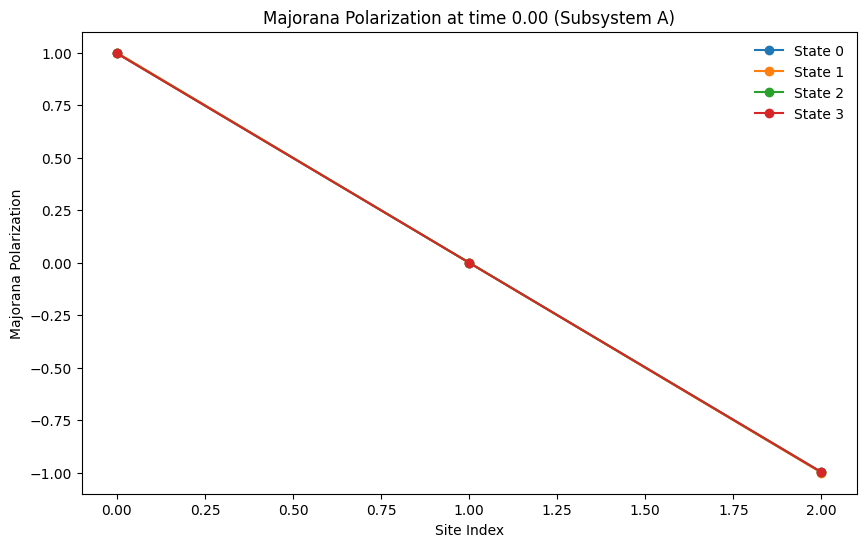

[[ 0.99987866+0.j -0.01640855+0.j -0.98347011+0.j]
 [ 0.99979803+0.j -0.01744808+0.j -0.98234995+0.j]
 [ 0.99975039-0.j -0.01532026-0.j -0.98443013+0.j]
 [ 0.99996077+0.j -0.01636457+0.j -0.9835962 +0.j]]


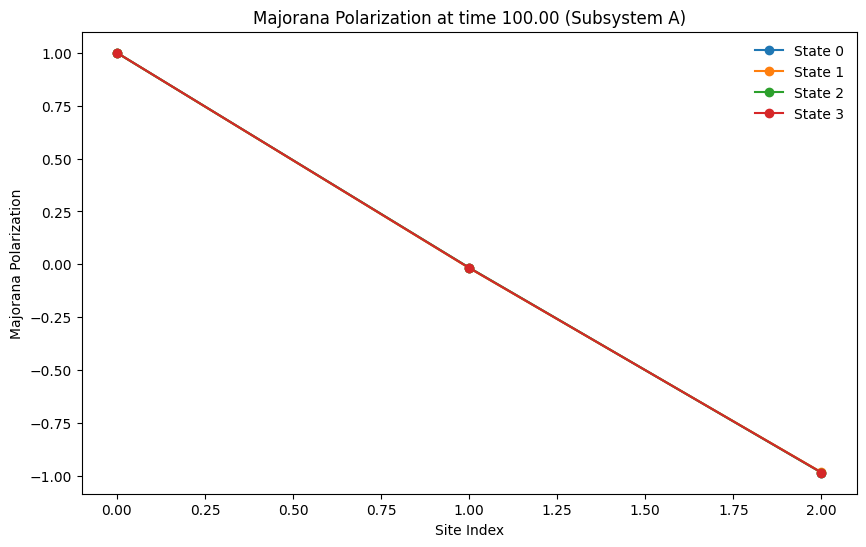

[[ 0.99987866+0.j -0.01640855+0.j -0.98347011+0.j]
 [ 0.99979803+0.j -0.01744808+0.j -0.98234995+0.j]
 [ 0.99975039-0.j -0.01532026-0.j -0.98443013+0.j]
 [ 0.99996077+0.j -0.01636457+0.j -0.9835962 -0.j]]


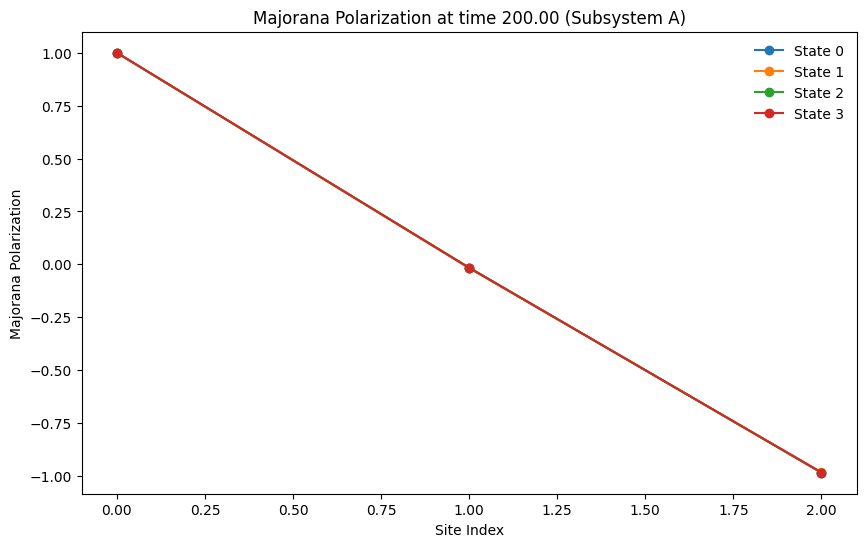

[[ 9.98822842e-01+0.j  1.73483167e-06-0.j -9.98824577e-01+0.j]
 [ 9.99998443e-01+0.j  3.41874881e-08+0.j -9.99998477e-01+0.j]
 [ 9.97103501e-01+0.j  4.25315623e-06+0.j -9.97107754e-01+0.j]
 [ 9.97054074e-01+0.j  2.25977432e-06+0.j -9.97056334e-01+0.j]]


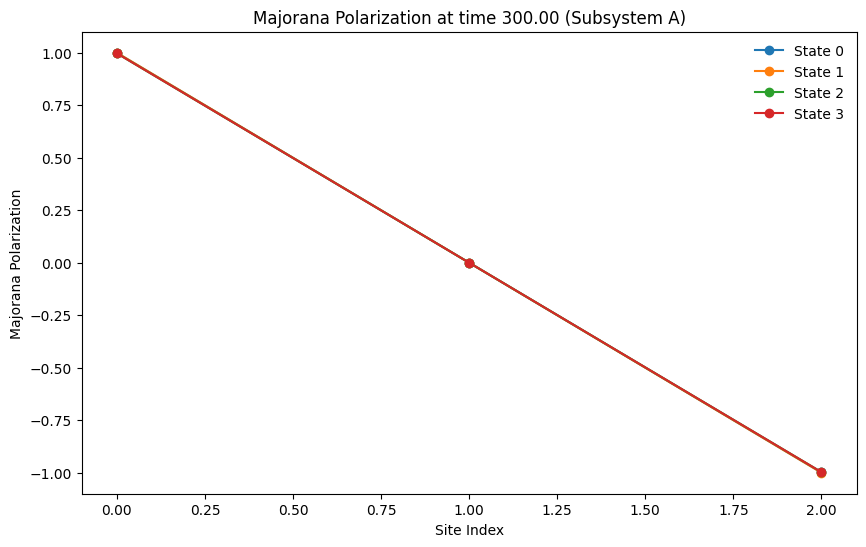

In [38]:
def construct_Gamma_operators(j,n):
    """Construct the Majorana operators Γ^s_j for site j in a chain of n sites."""
    f_dag_j, f_j = creation_annihilation(j, n)
    Gamma_1 = f_dag_j + f_j
    Gamma_2 = 1j * (f_dag_j - f_j)
    return Gamma_1, Gamma_2


def majorana_polarization(even_vecs, odd_vecs, n):
    M = np.zeros((even_vecs.shape[1], n), dtype=np.complex128)

    for j in range(n):
        Gamma_1, Gamma_2 = construct_Gamma_operators(j, n)
        for i in range(even_vecs.shape[1]):
            e = even_vecs[:,i]
            o = odd_vecs[:,i]
            term1 = np.vdot(o, Gamma_1 @ e)
            term2 = np.vdot(o, Gamma_2 @ e)
            M[i, j] = term1**2 + term2**2
    return M

# majorana_ops_A = majorana_operators(3)
times = [0, n_time_steps//3, 2*n_time_steps//3, n_time_steps-1]

for idx, time_idx in enumerate(times):
    M_A = majorana_polarization(even_vecs[idx], odd_vecs[idx], 3)
    print(M_A)
    plt.figure(figsize=(10,6))
    for i in range(M_A.shape[0]):
        plt.plot(range(3), M_A[i], 'o-', label=f'State {i}')
    plt.xlabel('Site Index')
    plt.ylabel('Majorana Polarization')
    plt.title(f'Majorana Polarization at time {time_array_A[time_idx]:.2f} (Subsystem A)')
    plt.legend(frameon=False)
    plt.show()

## Savings

In [ ]:
"""
Next:

1.
Check subsystem A, and how it evolves during braiding protocol.
Check the majorana polarization during the protocol for A.


2.
Compare berry phase for x energy levels at a time.
Compare with and without Coulomb interactions.

"""




# from scipy.linalg import svd

# def berry_unitary(eigvecs):
#     """
#     eigvecs: shape (Nt, dim, n_low)
#     returns: U_Berry (n_low x n_low)
#     """
#     Nt, dim, n_low = eigvecs.shape

#     U = np.eye(n_low, dtype=complex)

#     for i in range(Nt - 1):
#         Psi_t  = eigvecs[i]      # (dim, n_low)
#         Psi_tp = eigvecs[i + 1]  # (dim, n_low)

#         # overlap matrix
#         M = Psi_t.conj().T @ Psi_tp  # (n_low, n_low)

#         # polar decomposition → nearest unitary
#         U_m, _, Vh = svd(M)
#         M_unitary = U_m @ Vh

#         U = M_unitary @ U

#     return U

# print("Calculating Berry unitary...")
# U_Berry = berry_unitary(eigvecs)
# phase = np.linalg.det(U_Berry)**(1/lower_bound)
# U_Berry /= phase
# print("Berry unitary U_Berry:")
# # print(U_Berry)
# print(U_Berry.shape)
# print(np.sort(np.angle(np.linalg.eigvals(U_Berry))))


# H = big_H(n_sites, dupes, t, U, eps, Delta, couplings=couplings, eps_detune=eps_detune, operators=operators)

# ordered_couplings = {
#     "AB": {
#         "idx0": (0,2),
#         "idx1": (1,0),
#         "t_coup": None,
#         "Delta_coup": None
#     },
#     "eps_detune": None,
#     "BC": {
#         "idx0": (1,0),
#         "idx1": (2,0),
#         "t_coup": None,
#         "Delta_coup": None
#     },
# }


# def time_evolve(Total_time, n_steps, params, t_coup_max, Delta_coup_max, eps_detune_max, ordered_couplings, operators, lower_bound=10):

    
#     t_val, U_val, eps_val, Delta_val = params

#     couplings = []
#     eps_detune = {}
#     OC = ordered_couplings
#     for i in range(len(OC)): 
#         key = list(OC.keys())[i]
        
#         current = OC[key]
#         print(current)
#         if key == "eps_detune":
#             if current is not None:
#                 eps_detune = current
#             else: 
#                 eps_detune = {1: eps_detune_max}
#         else:
#             if current['t_coup'] is None:
#                 current['t_coup'] = t_coup_max
#             if current['Delta_coup'] is None:
#                 current['Delta_coup'] = Delta_coup_max
#             couplings.append([current['idx0'], current['idx1'], current['t_coup'], current['Delta_coup']])

#     print("Couplings for time evolution:", couplings)
#     print("Eps detune for time evolution:", eps_detune)


#     #Create Coupling pulse arrays:
#     time_array = np.linspace(0, Total_time, n_steps)
#     dt = time_array[1] - time_array[0]
#     ##Order of pulses AB peak at T=0 and T=Total_time, Eps Detune at T=Total_time/3, BC at T=2*Total_time/3
#     AB_t_peaks = [Total_time/3]#[0, Total_time]
#     BC_t_peaks = [2*Total_time/3]
#     eps_t_peaks = [0, Total_time]#[Total_time/3]

#     width = Total_time / 3
#     s = 20/width#Total_time * 6

#     All_Couplings = []
#     epsilons = []

#     # Precompute the pulses
#     for t in time_array:

#         eps_detune_val = simple_delta_pulse(t, eps_t_peaks[0], width, s, eps_detune_max , 0) + simple_delta_pulse(t, eps_t_peaks[1], width, s, eps_detune_max , 0)
#         epsilons.append(eps_detune_val)
        
#         current_couplings = []
#         for i,coup in enumerate(couplings):
#             # print(i, coup)
#             if i == 0:
#                 curr_t = simple_delta_pulse(t, AB_t_peaks[0], width, s, coup[2] , 0)# + simple_delta_pulse(t, AB_t_peaks[1], width, s, coup[2] , 0)
#                 curr_delta = simple_delta_pulse(t, AB_t_peaks[0], width, s, coup[3] , 0)# + simple_delta_pulse(t, AB_t_peaks[1], width, s, coup[3] , 0)
                
#                 current_coupling = [coup[0], coup[1], curr_t, curr_delta]
#                 current_couplings.append(current_coupling)
#             else:
#                 curr_t = simple_delta_pulse(t, BC_t_peaks[0], width, s, coup[2] , 0)
#                 curr_delta = simple_delta_pulse(t, BC_t_peaks[0], width, s, coup[3] , 0)
                
#                 current_coupling = [coup[0], coup[1], curr_t, curr_delta]
#                 current_couplings.append(current_coupling)

#         All_Couplings.append(current_couplings)
    

#     coupling_pulses = {
#         "AB_coupling": [All_Couplings[i][0] for i in range(len(All_Couplings))],
#         "BC_coupling": [All_Couplings[i][1] for i in range(len(All_Couplings))],
#         "eps_detune": epsilons
#     }

#     eigvals = np.zeros((n_steps, lower_bound))
#     eigvecs = np.zeros((n_steps, int(2**big_N), lower_bound), dtype=complex)
#     # Time Evolution
#     tJ = t_coup_max
#     dJ = Delta_coup_max
#     A = 0
#     B = 1
#     C = 2
#     gamma0_coupling = couplings = [
#     ((A,2), (B,0), tJ, dJ),
#     ((B,0), (C,0), tJ, dJ),
#     ((C,0), (A,2), tJ, dJ),
#     ]
#     #For each time step in ALL couplings, append gamma0coupling as well
#     for i in range(len(All_Couplings)):
#         for coup in gamma0_coupling:
#             All_Couplings[i].append(coup)
    
#     print(All_Couplings[0])

#     for i in tqdm(range(len(time_array))):
#         # H_t = big_H(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=All_Couplings[i], eps_detune={1: epsilons[i]}, operators=operators)
#         H_t = big_H(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=All_Couplings[i], eps_detune=0, operators=operators)
#         vals, vecs = np.linalg.eigh(H_t)
#         eigvals[i,:] = vals[:lower_bound]
#         eigvecs[i,:,:] = vecs[:,:lower_bound]

    
#     return eigvals, eigvecs, time_array, coupling_pulses
# T_total = 300
# n_steps = 1000
# t_coup_max = t_couple[0]/10
# Delta_coup_max = delta_couple[0]/10
# eps_detune_max = 1/10
# lower_bound = 8


# eigvals, eigvecs, time_array, coupling_pulses = time_evolve(T_total, n_steps, pars, t_coup_max, Delta_coup_max, eps_detune_max, ordered_couplings, operators, lower_bound=lower_bound)


def time_evolution(Total_time, n_steps, params, t_coup_max, Delta_coup_max, eps_detune_max, operators, lower_bound=10):
    print("Hei")
    t_val, U_val, eps_val, Delta_val = params

    tJ, dJ = t_coup_max, Delta_coup_max
    A = 0
    B = 1
    C = 2
    junction_mode = [
    ((A,2), (B,0), tJ, dJ),
    ((B,0), (C,0), tJ, dJ),
    ((C,0), (A,2), tJ, dJ),
    ]

    width = Total_time / 3
    s = 20/width#Total_time * 6

    time_array = np.linspace(0, Total_time, n_steps)
    dt = time_array[1] - time_array[0]

    eps_A_dict = {"site_idxs": [A], "node_idxs": [0], "vals": [0.0]}
    eps_B_dict = {"site_idxs": [B], "node_idxs": [2], "vals": [0.0]}
    eps_C_dict = {"site_idxs": [C], "node_idxs": [2], "vals": [0.0]}


    All_Couplings = []
    epsilons = []
    for t in time_array:
        eps_A = simple_delta_pulse(t, 0, width, s, eps_detune_max , 0) + simple_delta_pulse(t, Total_time, width, s, eps_detune_max , 0)
        eps_B = simple_delta_pulse(t, Total_time/3, width, s, eps_detune_max , 0)
        eps_C = simple_delta_pulse(t, 2*Total_time/3, width, s, eps_detune_max , 0)

        eps_A_dict["vals"] = [eps_A]
        eps_B_dict["vals"] = [eps_B]
        eps_C_dict["vals"] = [eps_C]
        epsilons.append([eps_A_dict, eps_B_dict, eps_C_dict])




        # AB_coup_t = simple_delta_pulse(t, 0, width, s, t_coup_max , 0) + simple_delta_pulse(t, Total_time, width, s, t_coup_max , 0)
        # AB_delta_t = simple_delta_pulse(t, 0, width, s, Delta_coup_max , 0) + simple_delta_pulse(t, Total_time, width, s, Delta_coup_max , 0)

        # BC_coup_t = simple_delta_pulse(t, Total_time/3, width, s, t_coup_max , 0)
        # BC_delta_t = simple_delta_pulse(t, Total_time/3, width, s, Delta_coup_max , 0)   

        # current_couplings = [
        #     ((A,2), (B,0), AB_coup_t, AB_delta_t),
        #     ((B,0), (C,0), BC_coup_t, BC_delta_t),
        # ]
        # junction mode
        # if t < Total_time / 3:
        #     current_couplings.append(junction_mode[0])
        # elif t < 2 * Total_time / 3:
        #     current_couplings.append(junction_mode[1])
        # else:
        #     current_couplings.append(junction_mode[2])

        # All_Couplings.append(current_couplings)
    
    pulse_info = {
        # "AB_coupling": [All_Couplings[i][0] for i in range(len(All_Couplings))],
        # "BC_coupling": [All_Couplings[i][1] for i in range(len(All_Couplings))],
        # "eps_detune": epsilons
        "epsA": [epsilons[i][0]["vals"] for i in range(len(epsilons))],
        "epsB": [epsilons[i][1]["vals"] for i in range(len(epsilons))],
        "epsC": [epsilons[i][2]["vals"] for i in range(len(epsilons))]
    }
    
    eigvals = np.zeros((n_steps, lower_bound))
    eigvecs = np.zeros((n_steps, int(2**big_N), lower_bound), dtype=complex)
    # Time Evolution
    for i in tqdm(range(len(time_array))):
        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=junction_mode, eps_detune=epsilons[i], operators=operators)
        vals, vecs = np.linalg.eigh(H_t)
        eigvals[i,:] = vals[:lower_bound]
        eigvecs[i,:,:] = vecs[:,:lower_bound]

    return eigvals, eigvecs, time_array, pulse_info




